##Introduction
In this google collab we are going to build a Keyword Detection model and export it to Lens Studio.
We will briefly go over the theory of audio processing and learn how to: 
*   Download audio dataset
*   Preprocess data
*   Download pretrained image classification model
*   Train and export model to Lens Studio


## Install libraries
First, we need to prepare our work environment and install the necessary Python packages. 

In [ ]:
!pip install torchaudio
!pip install librosa
!pip install antialiased_cnns

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

import torch
import torchaudio
import torch.backends.cudnn as cudnn
import torch.nn.init as init
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from torchaudio.datasets import SPEECHCOMMANDS
from torchvision.transforms import *

from PIL import Image
from IPython.display import Audio, display

import librosa
import librosa.display
from google.colab import files

from collections import Counter
import random
import os
from pathlib import Path

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

Let’s check if a CUDA GPU is available and select our device. Running the network on a GPU will greatly decrease the training/testing runtime.

In [4]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('DEVICE:', DEVICE)

def to_device(x):
    return x.to(DEVICE)

DEVICE: cuda:0


Set random seed to make all our experiments reproducible

In [5]:
def fixSeed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed = 1337
fixSeed(seed)

And define some constants we are going to use for training.

> *Note :* These settings have to match the settings in Lens Studio project



In [6]:
SAMPLE_RATE = 16000         # Number of samples per second
IMAGE_SIZE = 128            # Spectrogram image size
N_FFT = 2048                # Length of the fft window 
FRAME_SIZE = 512            # Length of the window, the window will be the length of frameSize and then padded with zeros to mach N_FFT
HOP_SIZE = 128              # Number of samples between successive fft segments
NUM_MEL = 128               # Number of mel frequency bins, have to match image size
MIN_FREQ = 0                # Min frequency
MAX_FREQ = 8000             # Max frequency
HTK = True

In [7]:
WORKING_DIR_PATH = Path('/content')  

##Download dataset

We use torchaudio to download and represent the dataset. Here we use [SpeechCommands](https://arxiv.org/abs/1804.03209), which is a dataset of 35 commands spoken by different people. The dataset SPEECHCOMMANDS is a `torch.utils.data.Dataset` version of the dataset.  In this dataset all audio files are about 1 second long with sample rate of 16000 samples per second.
The actual loading and formatting steps happen when a data point is being accessed, and torchaudio takes care of converting the audio files to tensors. If one wants to load an audio file directly instead, `torchaudio.load()` can be used. 



Here we create a subclass that splits dataset into standard training and validation subsets. More details about speech command recognition with torch audio can be found on the [website](https://pytorch.org/tutorials/intermediate/speech_command_recognition_with_torchaudio.html). 

In [8]:
class SpeechCommandsSubset(SPEECHCOMMANDS): 
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.join(self._path, line.strip()) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

In [9]:
train_set = SpeechCommandsSubset("training")
validation_set = SpeechCommandsSubset("validation")

A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform (a curve showing the amplitude of a soundwave at a given time), the sample rate, the label and other metadata. However if you use `torchaudio.load()` it returns a tuple containing only tensor and a sample rate.

In [10]:
waveform, sample_rate, label, speaker_id, utterance_number = train_set[random.randint(0, len(train_set))]

print("Label: {}".format(label))
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

display(Audio(waveform, rate=sample_rate))


Label: three
Shape of waveform: torch.Size([1, 15531])
Sample rate of waveform: 16000


## Explore the data

The first step before model-training is always exploring and analyzing the data. Let's see how many samples we have, how many samples of each label etc.


Number of datapoints = 105829   Number of classes = 35
Classes:  ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


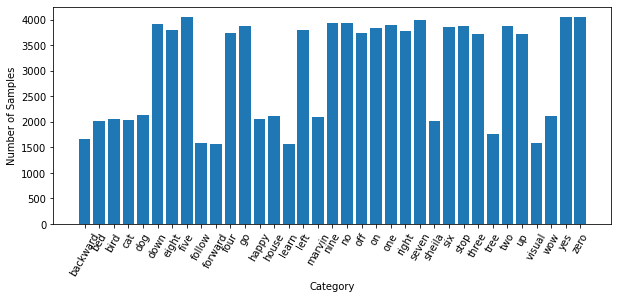

In [11]:
occurrences = Counter([datapoint[2] for datapoint in train_set])
labels = list(occurrences.keys())

print("Number of datapoints =", len(train_set), "  Number of classes =", len(labels))
print("Classes: " , labels)

plt.figure(figsize=(10,4))
plt.bar(occurrences.keys(), occurrences.values())
plt.xticks(rotation = 60)
plt.xlabel("Category")
plt.ylabel("Number of Samples");

Sometimes we are interested only in certain subset of labels (keywords). We can combine all orher samples into one class.
Let's define some possible subsets:

In [12]:
ALL = {'backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero'}
NUMBERS = {'zero','one','two','three','four','five','six','seven','eight','nine'}
DIRECTIONS = {'up', "down", "left", "right", "forward", "backward"}

In [13]:
subset = ALL                # ALL, NUMBERS, DIRECTIONS
OTHER_LABEL = "__other"

In [14]:
LABEL_TO_INDEX = {}
INDEX_TO_LABEL = []
idx = 0
for l in labels:
    if l in subset:
        LABEL_TO_INDEX[l] = idx
        INDEX_TO_LABEL.append(l);
        idx = idx + 1
    else: 
        LABEL_TO_INDEX[l] = len(subset)

if len(labels) > len(subset): 
    INDEX_TO_LABEL.append(OTHER_LABEL);
LABELS_COUNT = len(INDEX_TO_LABEL)

print(INDEX_TO_LABEL)

['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


## [Understanding Mel Spectrogram ](https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53)

Let's go over some audio processing theory.
A waveform is a curve showing the amplitude of the soundwave (y-axis) at time T (x-axis). Let's check out the waveform of our audio clip.



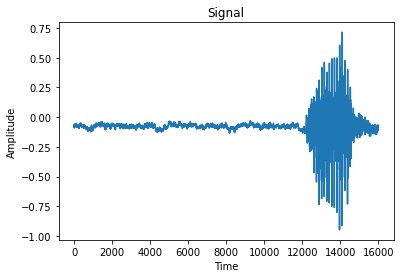

In [15]:
waveform, *_ = train_set[0]
signal = waveform.t().numpy()[:,0];
plt.plot(signal);
plt.title('Signal');
plt.xlabel('Time');
plt.ylabel('Amplitude');

An audio signal consists of a set of single-frequency sound waves. When taking samples of the signal over time, we only capture the resulting amplitudes. The Fourier transform is a mathematical formula that allows us to decompose a signal into it’s individual frequencies and the frequency’s amplitude. In other words, it converts the signal from the time domain into the frequency domain. The result is called a spectrum.



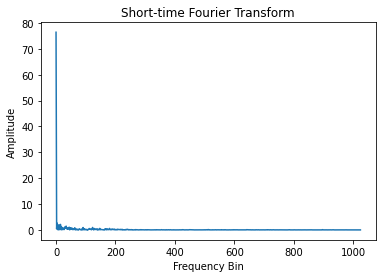

In [16]:
ft = np.abs(librosa.stft(signal[:N_FFT], hop_length = N_FFT+1))
plt.plot(ft);
plt.title('Short-time Fourier Transform')
plt.xlabel('Frequency Bin');
plt.ylabel('Amplitude');


The spectrum of most music or speech audio signals varies over time and can't be represented with one Fourier transform. If we compute  a Fourier transform applied to small overlapping segments of a signal we get a Spectrogram

Text(0.5, 1.0, 'Spectrogram')

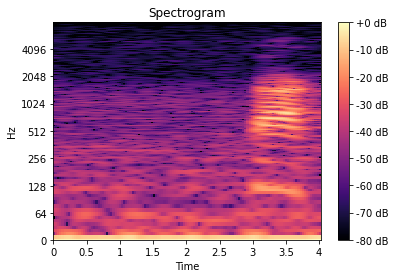

In [17]:
spec = np.abs(librosa.stft(signal, hop_length=HOP_SIZE))
spec = librosa.amplitude_to_db(spec, ref=np.max)
librosa.display.specshow(spec, sr=sample_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')

A spectrogram converted to a Mel Scale (that better represents the way human's ear perceives different frequencies) is called MelSpectrogram 


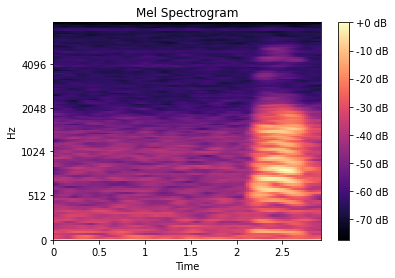

In [18]:
mel_spect = librosa.feature.melspectrogram(y=signal, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_SIZE, n_mels = NUM_MEL)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
librosa.display.specshow(mel_spect, y_axis='mel', fmax=MAX_FREQ, x_axis='time')
plt.title('Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')

## Create dataloaders

For loading the data, we have to create a dataset and a data loader for train and validation sets.

A dataset is an iterator-like object that returns an image and its label at every step. A loader is an object that aggregates the output of the dataset and returns batches.

We will be creating training image recognition network and need to create spectrogram image from each waveform.




In [19]:
BATCH_SIZE = 128
BATCH_SIZE_VAL = 128

Defining helper functions that convert waveform to the image with 3 channels


In [20]:
def log_spectrogram(audio):
    spec = librosa.feature.melspectrogram(y=audio, 
                                          sr=SAMPLE_RATE, 
                                          n_fft=N_FFT, 
                                          win_length=FRAME_SIZE, 
                                          hop_length=HOP_SIZE, 
                                          htk=HTK)
    spec = librosa.power_to_db(spec, ref=np.max)
    return spec

We can convert an array of numbers to image by stacking the X value in R,G and B channels. Notice that standardization of data is done here and later it is multiplied by 255.

In [21]:
def spectrogram_to_image(x, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    x = np.stack([x, x, x], axis=-1)
    # Standardize
    mean = mean or x.mean()
    std = std or x.std()
    xstd = (x - mean) / (std + eps)
    _min, _max = xstd.min(), xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # clamp
        v = xstd
        v[v < norm_min] = norm_min
        v[v > norm_max] = norm_max
        # Scale to [0, 255]
        v = 255 * (v - norm_min) / (norm_max - norm_min)
        v = v.astype(np.uint8)
    else:
        # Just zero
        v = np.zeros_like(xstd, dtype=np.uint8)
    return v

Let's make our own custom transform which creates image from the each wav file. If you are going to use this notebook at home computer we recommend you to convert all images from the audio files only once.

In [22]:
class ToSpectrogram(object):
    def __init__(self):
        pass

    def __call__(self, sample):
        sample = sample.squeeze(0).numpy()
        spec = log_spectrogram(sample)
        image = spectrogram_to_image(spec)
        return image


We are also adding some augmentations to the spectrogram image. If you think about it - random spectrogram image translation corresponds to shift in time or pitch, scale - to the speed of the person's speach, random erasing - to some noise.

You can experiment with adding audio specific transforms instead (before converting to the image).

In [23]:
transform_train = transforms.Compose([
        ToSpectrogram(),
        transforms.ToPILImage(),
        transforms.ColorJitter(.4,.4,.4),
        transforms.RandomAffine(0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.RandomCrop((IMAGE_SIZE, IMAGE_SIZE),pad_if_needed=True),
        transforms.ToTensor(),
        transforms.RandomErasing(scale=(0.02, 0.25),), 
    ])

transform_test = transforms.Compose([
        ToSpectrogram(),
        transforms.ToPILImage(),
        transforms.CenterCrop((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
    ])


The Dataset object loads audio file from disk and applies the transforms to it. It returns a transformed image and the corresponding label. 

Default dataset returns label name as string and doesn't support transforms inside. That's why we created our own wrapper to provide additional functionality.

In [24]:
class SpeechCommandsDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        self.labels = LABEL_TO_INDEX
    def __getitem__(self, index):
        waveform, sample_rate, label, *_ = self.subset[index]
        if self.transform:
            spectrogram = self.transform(waveform)
        
        idx = self.labels[label]
        return spectrogram, idx
        
    def __len__(self):
        return len(self.subset)

Create Train and Validation datasets:

In [25]:
train_set = SpeechCommandsDataset(train_set, transform_train)
validation_set = SpeechCommandsDataset(validation_set, transform_test)

Now we can create the loaders. The train one will shuffle samples, the validation one will just return the images from the validation dataset.

In [26]:
train_loader = data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
validation_loader = data.DataLoader(validation_set, batch_size=BATCH_SIZE_VAL, shuffle=False, num_workers=0)

Let's define helper functions for displaying grid of images and then check the result by displaying samples from train and validation datasets:

In [27]:
def imshow(img):
    img = torch.clamp(img, 0.0, 1.0)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')

def load_and_show(loader, count):
    cols = int(math.sqrt(count))
    rows = int(math.ceil(count / cols))
    plt.figure(figsize=(12, 12))
    dataiter = iter(loader)
    images, labels = dataiter.next()  
    for r in range(rows):
      for c in range(cols):
        if (cols * r + c) >= count:
          continue;
        plt.subplot(rows, cols, cols * r + c + 1)
        imshow(images[cols * r + c])
        plt.axis('off')
        plt.title(INDEX_TO_LABEL[labels[cols * r + c].item()])
    plt.show()

Train samples :


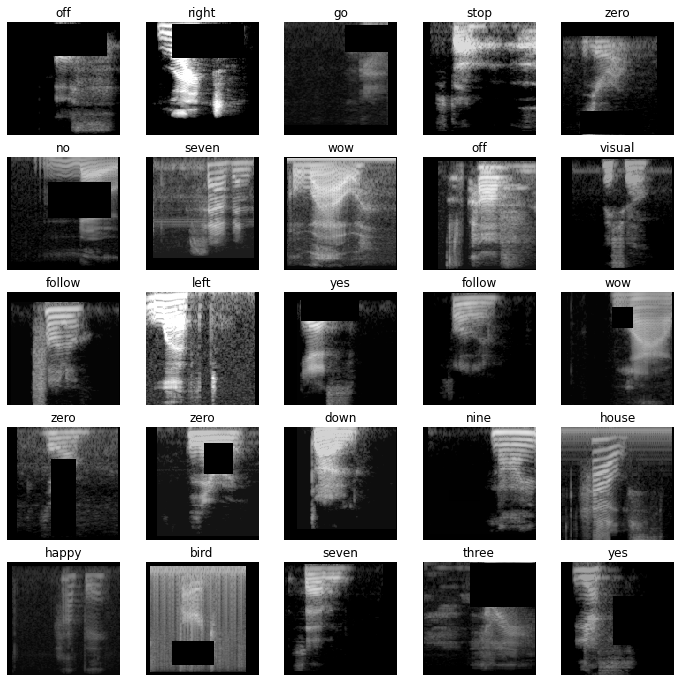

Validation samples :


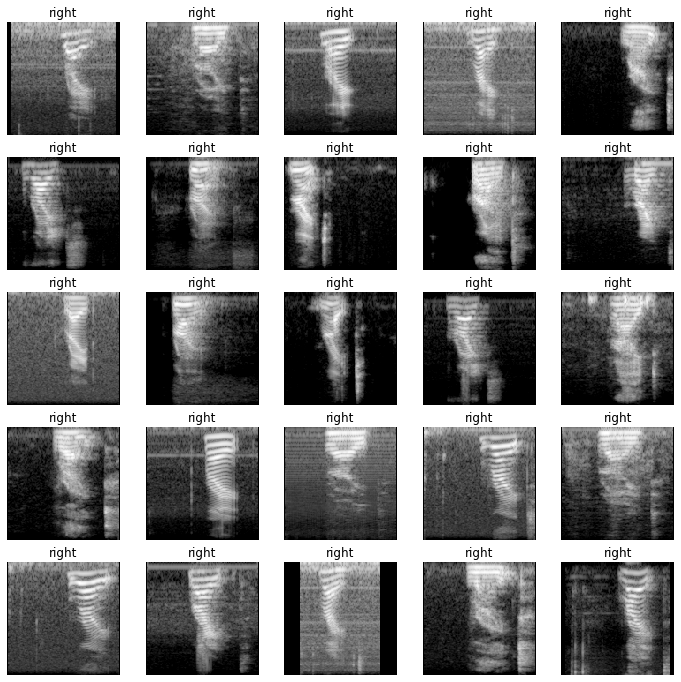

In [28]:
print("Train samples :")
load_and_show(train_loader, 25)
print("Validation samples :")
load_and_show(validation_loader, 25)

You might notice that in produced images start coordinate is top left (frequency increases from the top to bottom). This is the way textures are represented in open gl and how we create them in Lens Studio template. Therefore we make sure that training samples have same parameters as the realtime data.

#Model

Our model will use pretrained weights of MobilenetV2. For this application we are going to download antialiased MobileNetV2 model.

Antialiasing applied to deep networks can make them shift-invariant, stabilize outputs and improve accuracy. Which alligns well with the audio processing application. You can read more about [antialiased cnns here](https://richzhang.github.io/antialiased-cnns/).

**Modifications**:
* Relu6 is replaced with Relu. Make sure that you do the same for your custom architectures because CoreML doesn't support Relu6.
* Replaced 2 layers at the end - Dropout and Linear


In [29]:
def load_mobilenet_v2(pretrained=False, width = 0.5, antialiased=True):
    if antialiased:
        import torchvision.models as models
        import antialiased_cnns
        model = antialiased_cnns.mobilenet_v2(pretrained=pretrained,filter_size=4,
                                              _force_nonfinetuned=False, 
                                              width_mult=width) 
        model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(model.last_channel, LABELS_COUNT))
    else:
        model = torchvision.models.mobilenet_v2(pretrained=pretrained, width_mult=width)
    return model

In [30]:
def replace_relu6_with_relu(model):
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            model._modules[name] = replace_relu6_with_relu(model=module)
        if isinstance(module, nn.ReLU6):
            model._modules[name] = nn.ReLU()
    return model

Defining function that loads the weights from a full width MobilenetV2 model to our custom width model

In [31]:
def preprocess_model(model):
    state_dict = load_mobilenet_v2(True, 1.0).state_dict()
    target_dict = model.state_dict()
    for k in target_dict.keys():
        if len(target_dict[k].size()) == 0:
            continue
        state_dict[k] = state_dict[k][:target_dict[k].size(0)]
        if len(state_dict[k].size()) > 1:
            state_dict[k] = state_dict[k][:, :target_dict[k].size(1)]

    model.load_state_dict(state_dict)
    model = replace_relu6_with_relu(model)
    return model

In [32]:
net = load_mobilenet_v2()
net = preprocess_model(net)
net = to_device(net)

Downloading: "https://antialiased-cnns.s3.us-east-2.amazonaws.com/weights_v0.1/mobilenet_v2_lpf4_finetune-7eed94b1.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2_lpf4_finetune-7eed94b1.pth


#Loss and Optimizer
One of the most significant parts of the model training process is a loss function. For Multi-class classification — we use multi-class cross-entropy — a specific case of cross-entropy where the target is a one-hot encoded vector. 

We are using Adam optimizer that combines the best properties of the AdaGrad and RMSProp algorithms, is fast and easy to configure.

Good default settings are lr=0.001, beta1=0.9, beta2=0.999 and epsilon=10−8

In [33]:
LR = 8e-4                      # Learning rate
BETA1 = 0.9                    # Coefficient used for computing running averages of gradient and its square
BETA2 = 0.99                   # Coefficient used for computing running averages of gradient and its square
WEIGHT_DECAY = 1e-4            # Weight decay coefficient
EPSILON = 1e-08                # Term added to the denominator to improve numerical stability

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=LR, betas=(BETA1,BETA2), weight_decay=WEIGHT_DECAY, eps=EPSILON)

For validation, we will use the following function:

In [35]:
def valid(net):
  net.eval()  
  average_loss = 0
  average_acc = 0
  bn = 0
  with torch.no_grad():
      pbar2 = tqdm(enumerate(validation_loader), total=len(validation_loader))
      for i, (input, target) in pbar2:
          input_var = to_device(input)
          target_var = to_device(target)

          output = net(input_var)
          loss = criterion(output, target_var)

          accuracy = (torch.softmax(output, dim=1).argmax(dim=1) == target_var).sum().float() / float( target.size(0) )
          bn += 1
          average_loss = average_loss + loss.item()
          average_acc = average_acc + accuracy.item()
          pbar2.set_description("Loss:{:.5f} Accuracy:{:.5f}".format(average_loss/bn, average_acc/bn))
  return average_acc/bn


We'll also define some functions to generate a [confustion matrix ](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62)

In [36]:
def plot_confusion_matrix(array):
    df_cm = pd.DataFrame(array, range(LABELS_COUNT), range(LABELS_COUNT))
    plt.figure(figsize=(LABELS_COUNT,LABELS_COUNT))
    sn.set(font_scale=1.0) 
    sn.heatmap(df_cm, annot=True) 
    plt.show()

def print_confusion_matrix(net):
    net.eval()
    nb_classes = LABELS_COUNT
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        pbar2 = tqdm(enumerate(validation_loader), total=len(validation_loader))
        for i, (inputs, classes) in pbar2:
            inputs = to_device(inputs)
            classes = to_device(classes)
            outputs = net(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
    
    
    print('per class matrix:')
    print(confusion_matrix.diag()/confusion_matrix.sum(1))
    return confusion_matrix/confusion_matrix.sum(1)

#Training loop
It's time to write the main training loop. There are actually two loops, one for epochs and another for batches. We will perform validation every epoch.

In [37]:
EPOCHS = 5

In [ ]:
best_checkpoint = None
best_acc = np.float('-inf')

for epoch in range(EPOCHS):
    moving_loss = 0
    moving_acc = 0
    bn = 0
    net.train()
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (input, target) in pbar:
        x = to_device(input)
        y = to_device(target)
        output = net(x)
        classification_loss = criterion(output, y)

        loss = classification_loss
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        accuracy = (torch.softmax(output, dim=1).argmax(dim=1) == y).sum().float() / float( y.size(0) )
        moving_loss = moving_loss * (bn / (bn + 1)) + loss.item() / (bn + 1)
        moving_acc = moving_acc * (bn / (bn + 1)) + accuracy.item() / (bn + 1)
        bn += 1
        pbar.set_description("[{}] Loss:{:.5f} Accuracy:{:.5f}".format(epoch, 
                             moving_loss, moving_acc))
    acc = valid(net)
    if best_checkpoint is None or acc > best_acc:
        best_acc = acc
        best_checkpoint = WORKING_DIR_PATH / f'classifier-{epoch}-{best_acc:0.2f}.pth'
        torch.save(net.state_dict(), best_checkpoint)

In [39]:
# Replace this if your best checkpoint is something else. You 
# can view your best checkpoint by simply running `print(best_checkpoint)`

#CHECKPOINT_TO_LOAD = '/content/classifier-0-0.98.pth'
#net.load_state_dict(torch.load(CHECKPOINT_TO_LOAD)) 
#net = to_device(net)

In [40]:
net.eval()
matrix = print_confusion_matrix(net)


per class matrix:
tensor([0.8889, 0.8826, 0.9231, 0.9944, 0.9797, 0.9655, 0.9884, 0.9782, 0.8485,
        0.6781, 0.9464, 0.8387, 0.9726, 0.9846, 0.8906, 0.9830, 0.9487, 0.9719,
        0.8719, 0.9464, 0.9559, 0.9516, 0.9752, 0.9509, 0.9510, 0.9788, 0.9629,
        0.9579, 0.8931, 0.9536, 0.9657, 0.9496, 0.9067, 0.9899, 0.9661])


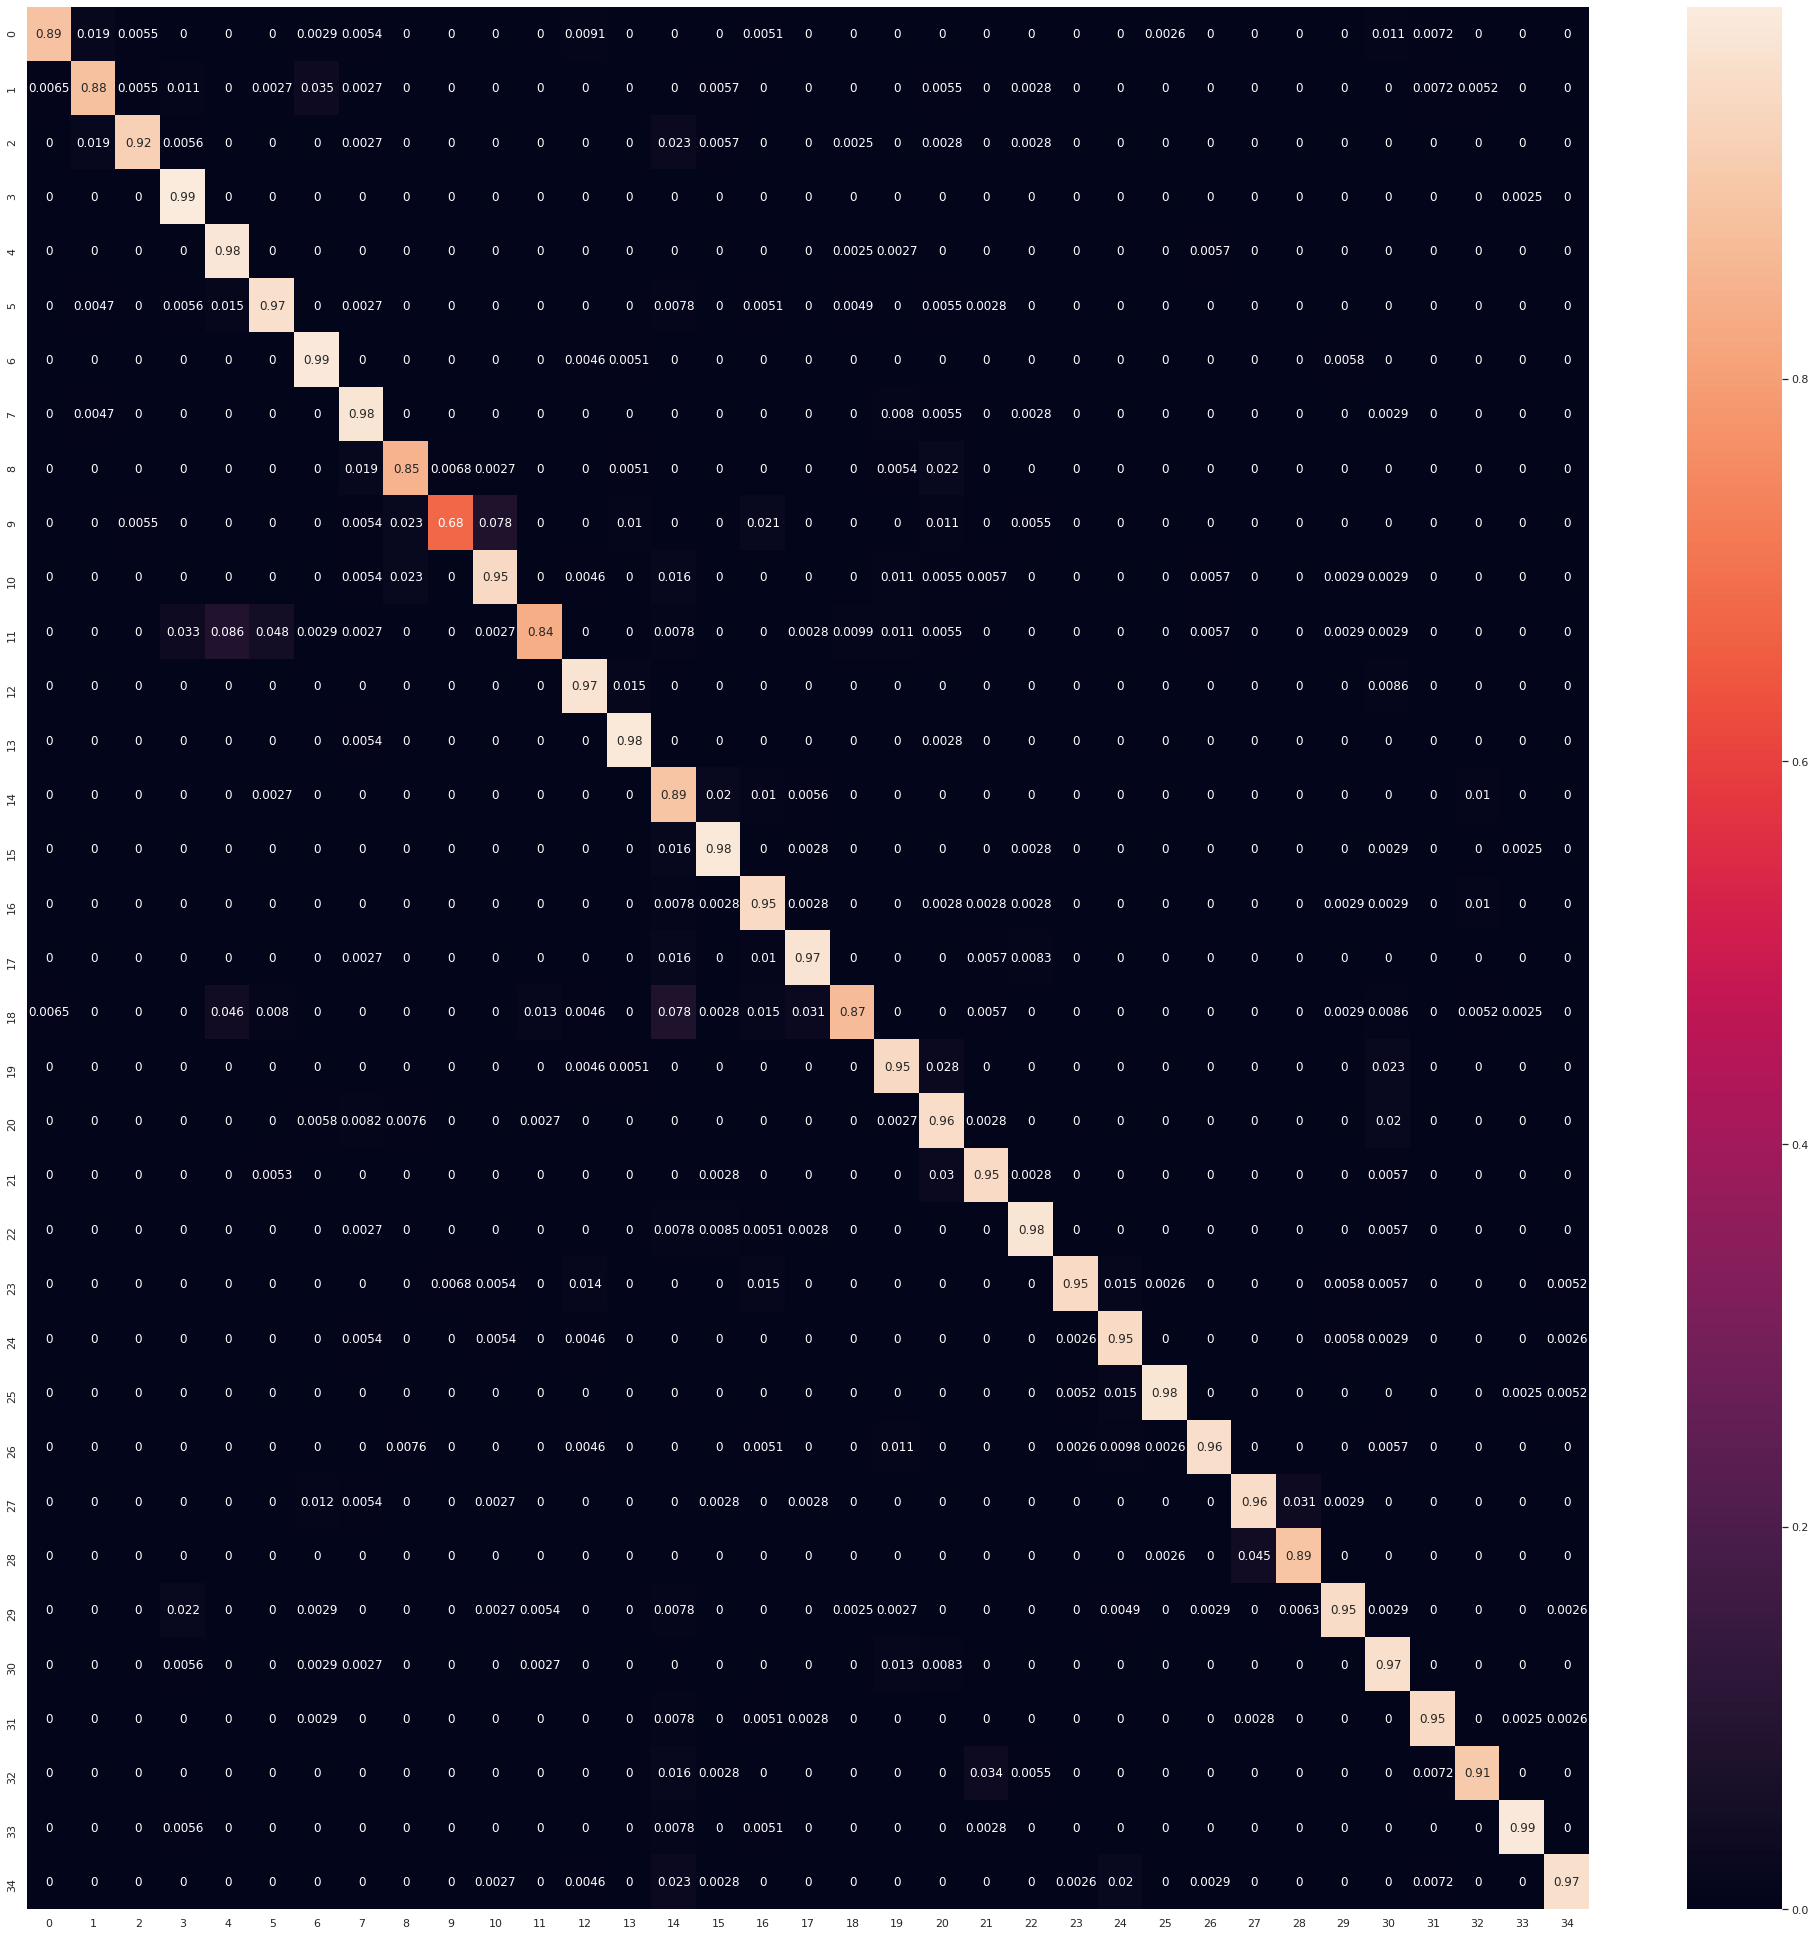

In [41]:
plot_confusion_matrix(matrix.numpy())

# Export

It's time to convert our model to a universal format ONNX so that the model could be used in a lens.

We trained our model on images with pixel values from the range `[0, 1]`but Lens Studio passes images with the range `[0, 255]` to the input. There are several options:

- Set scale and bias coefficients in Lens Studio on importing the model.
- Divide the input image by 255 right inside the model or equivalently divide the weights of the first convolution.
- Create a wrapper for the model that prepares inputs (we don't recommend you do that because it adds axtra operations to the model).

We will choose the second option, but if you think that the approach is tricky, you can set normalization options in Lens Studio. Anyway, it's very important to use the same normalization both for training and production.

In [42]:
net.features[0][0].weight.data /= 255.0

In [43]:
INPUT_NAME = 'input'
OUTPUT_NAME = 'prob'

ONNX_PATH =  'classifier' + str(LABELS_COUNT) + '.onnx' 
LABELS_PATH = 'labels' + str(LABELS_COUNT) +'.js'

In [ ]:
dummy_input = torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE, device='cuda')
net = net.eval()

input_names = [INPUT_NAME]
output_names = [OUTPUT_NAME]

torch.onnx.export(net, 
                  dummy_input, 
                  ONNX_PATH, verbose=False, 
                  input_names=input_names, 
                  output_names=output_names,
                  opset_version=10,
                  operator_export_type=torch.onnx.OperatorExportTypes.ONNX_ATEN_FALLBACK)


Now let's download .onnx file along with .js file with labels that can be used in Keyword Detection template

In [45]:
def write_labels_to_file(file_path):
    f = open(LABELS_PATH, "w")
    f.write("var labels = " + str(INDEX_TO_LABEL) + ";\nscript.api.labels = labels;");
    f.close()
write_labels_to_file(LABELS_PATH)

In [ ]:
def download_file(file_path):
    files.download(file_path)

## Download ONNX from Colab
download_file(ONNX_PATH)

## Create file with labels for the Lens Studio template
download_file(LABELS_PATH)


Once the model and labels files downloaded please refer to the template quide [here](https://lensstudio.snapchat.com/templates/audio/keyword-detection/)